# Homework 1
The goal of this homework is to make sure that you have your environment set up, and get a little bit of practice with pytorch. Some of the examples and tutorial components are helpfully drawn from the [UVA DL course](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html).

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import torch
print("Using torch", torch.__version__)

Using torch 2.4.0+cu121


Generally, we want all of our code to be reproducible, so we're going to set a random number generator seed. This will make sure that our random initializations are the same every time we run the code. This is important for reproducibility. Why? Well, if you get some kind of error then this error will deterministically happen which makes debugging easier for you and anyone else who might try to help you!

In [3]:
torch.manual_seed(0)

# An introduction to PyTorch
You can think of PyTorch as Numpy + autodifferentiation. That means, it has a numpy-like syntax but also allows you to take derivatives of arbitrary differentiable functions. 

The core object in PyTorch is the Tensor. A Tensor is the equivalent of a numpy array but with a few extra features. For example, you can move a tensor to the GPU to speed up computation and operation on tensors are tracked to build a computation graph. This allows you to take the derivative of a tensor with respect to some other tensor.

## Playing around with tensors
Here are some basic tensor operations that you'll use pretty often
- `torch.zeros`: Creates a tensor filled with zeros
- `torch.ones`: Creates a tensor filled with ones
- `torch.rand`: Creates a tensor with random values uniformly sampled between 0 and 1
- `torch.randn`: Creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1
- `torch.arange`: Creates a tensor containing the values in the indicated range
- `torch.Tensor` (input list): Creates a tensor from the list elements you provide

In [4]:
## Some examples
print('a tensor filled with 1, 2, 3')
x = torch.tensor([1, 2, 3])
print(x)
print(x.size())

print(' a 2x3 tensor filled with zeros')
x = torch.zeros((2, 3))
print(x)
print(x.size())

a tensor filled with 1, 2, 3
tensor([1, 2, 3])
torch.Size([3])
 a 2x3 tensor filled with zeros
tensor([[0., 0., 0.],
        [0., 0., 0.]])
torch.Size([2, 3])


## Interoperability with numpy
Often-times we'll want to do a bunch of pytorch operations but in the end export things to Numpy so that we can plot in matplotlib or do some other operation. PyTorch tensors can be converted to numpy arrays and vice-versa very easily.

- `torch.Tensor.numpy()`: Converts a torch Tensor to a numpy array
- `torch.Tensor.from_numpy()`: Converts a numpy array to a torch Tensor
so for example if you have a torch tensor `a` you can call `a.numpy()` to get a numpy array.
or if you have a numpy tensor b you can call `torch.from_numpy(b)` to get a torch tensor or `torch.tensor(b)`.

In [5]:
import numpy as np
b = np.array([1, 2, 3])
x = torch.tensor(b)
x = torch.from_numpy(b)
c = x.numpy()

## Basic and important operations
Torch supports all sorts of standard operations like in numpy. You can add and subtract tensors together, multiply them by a constant, etc. However, the operations we will care the most about are matrix multiplies. In PyTorch, you can do a matrix multiply by using the `torch.matmul` function. You can also do elementwise multiplication using the `@` operator.

In [8]:
a = torch.ones((2,3))
b = torch.ones((3))
c = a@b
print(c)

tensor([3., 3.])


Importantly, these matrix operations can be broadcasted or batched. Often-times (you'll see) we want to take a single matrix and apply it to a lot of data. For example, we might have an NxP matrix and M datapoints of shape (M, P). For each of the datapoints, we want to form the matrix-vector product. One way we could do this is to simply iterate through the data-points one at a time and multiply the matrix by the vector. However, this is very slow. Instead, we want to use what's known as `broadcasting` to multiply them all in one operation. Broadcasting takes an additional dimension and expands the operation over it. 

We can multiply the matrix by all of the datapoints at once using broadcasting. The two syntaxes for doing this are:
- torch.matmul(a, b)
- a@b
    
where a is a tensor of shape (N, P) and b is a tensor of shape (P, M, 1). The result will be a tensor of shape (N, M, 1).

In [22]:
import time
# an example of matrix multiplication broadcasting
num_data = 10000
matrix = torch.ones((5,4))
vector = torch.ones(((num_data,4, 1)))

# first lets do this in a for loop
t = time.time()
for index in range(vector.shape[0]):
    matrix @ vector[index]
loop_time = time.time()-t
print('time to for loop ', loop_time)

# then lets broadcast it
t = time.time()
(matrix @ vector).shape
broadcast_time = time.time()-t
print('time to broadcast ', broadcast_time)
print(f'broadcasting is {loop_time / broadcast_time} times faster')

# for you to fill in - can you do the same thing but for a dot product operation instead? That is, we have a vector of size (num_data, N) and we want to dot product it with a vector of size (N, 1).


time to for loop  0.019169092178344727
time to broadcast  0.00030732154846191406
broadcasting is 62.374709076803725 times faster


## Indexing
Just like in numpy, we often want to index into tensors. This is done using the square bracket notation. For example, if we have a tensor `a` we can get the first element by calling `a[0]`. We can also get a range of elements by calling `a[1:3]` or access a specific axis as `a[1,:]` which for a 2-d tensor will take the 1st element of the first axis and return all the other axes. We can also use boolean indexing to get all elements that satisfy a certain condition. For example, if we want all elements greater than 3 we can call `a[a > 3]`.

# One of the cool things in PyTorch is that tensor operations can easily be differentiated. Each tensor has a `requires_grad` attribute, and if it is set to True, then operations on the tensor will be tracked. You can then call `.backward()` on the final tensor to compute the gradients of that tensor with respect to all the tensors that have `requires_grad` set to True. This is a very powerful feature that allows us to easily compute gradients of complex functions. Lets see an example of this below.

In [68]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True) # Only float tensors can have gradients. Float32 means that the tensor is represented by 32 bits. It can roughly represent numbers between -3.4e38 and 3.4e38 and can represent about 7 decimal places. Later, we'll go into why we care about how many decimals can be represented.
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()
print("Y", y)

# we can inspect each of the intermediate variables
# to see what gradient function is associated with each
print(x.grad_fn)
print(a.grad_fn)
print(b.grad_fn)
print(c.grad_fn)

# if we call backward on y, we are asking pytorch to compute the gradient of y with respect to all the tensors that have requires_grad=True. This should be all of them because they are all dependent on x.
y.backward()
print(x.grad) # the gradient of y with respect to x

Y tensor(12.6667, grad_fn=<MeanBackward0>)
None
tensor([1.3333, 2.0000, 2.6667])


This computation graph looks like

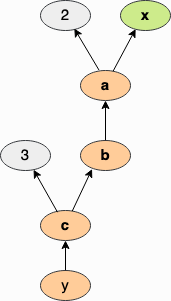

where the arrows point in the direction of the gradient flow and variables that have derivatives are colored orange.

How is this gradient computed? Well, it's basically done by the chain rule.
$$\frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx}$$
where $u$ is some intermediate variable. This is done recursively for all the intermediate variables. So extending it out we have
$$\frac{dy}{dx_i} = \frac{dy}{dc_i} \frac{dc_i}{db_i} \frac{db_i}{da_i} \frac{da_i}{dx_i}$$
Note the indices, some of these variables are vectors. 
and if we do all those out we have
$$\frac{da_i}{dx_i} = 1$$
$$\frac{db_i}{da_i} = 2a_i$$
$$\frac{dc_i}{db_i} = 1$$
$$\frac{dy}{dc_i} = 1/3$$
and if you multiple this out you should get the right thing. 

# Question 1 - Gradient Descent practice
In lecture 1 (in the notes), we learned about gradient descent, a common optimization algorithm used to minimize losses in deep learning. Now lets implement gradient descent for logistic regression. Remember from the lecture notes that the predictor in logistic regression is $$p(y=1|x, \theta) = \frac{1}{1 + \exp(-w^Tx + b)}$$ where $\theta = [w,b]$. 

Now, for a given data pair ${x_i, y_i}$, the likelihood of that datapoint is given by $$L(w) = y_i \log(p(y=1|x_i)) + (1 - y_i) \log(1 - p(y=1|x_i))$$ and for the entire dataset we get the log-likelihood $$L(w) = \sum_{i=1}^N y_i \log(p(y=1|x_i)) + (1 - y_i) \log(1 - p(y=1|x_i))$$

## Part 1
Write out the gradients of the likelihood $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$. You can write them here in the notebook using LaTex.

$$\frac{\partial L}{\partial w} = ?$$

$$\frac{\partial L}{\partial b} = ?$$

## Part 2
I've generated the following dataset that can almost be separated by a line. Your job is to implement gradient descent to find the values of $w$ and $b$ that minimize the negative log-likelihood. Note that the data is completely linearly separable so you should still be able to get a perfect classifier.

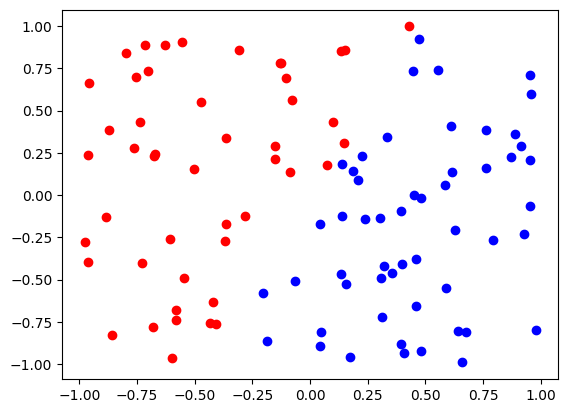

In [49]:
with open('Data/Homework_1/linear_data.pkl', 'rb') as f:
    data = pkl.load(f)
    x, y = data
# plot the data, coloring y = 1 as red and 0 as blueß
plt.figure()
plt.scatter(x[y==1, 0], x[y==1, 1], color='red')
plt.scatter(x[y==0, 0], x[y==0, 1], color='blue')
plt.show()


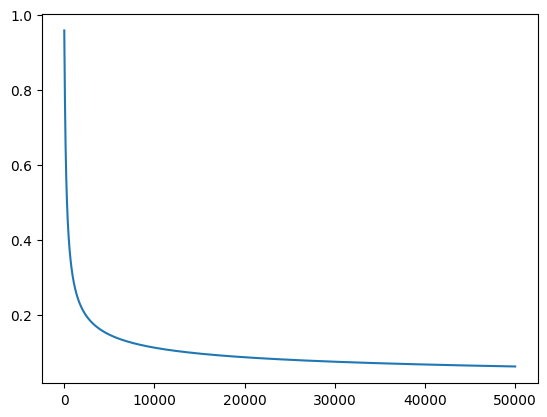

/tmp/ipykernel_1005378/2925380819.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


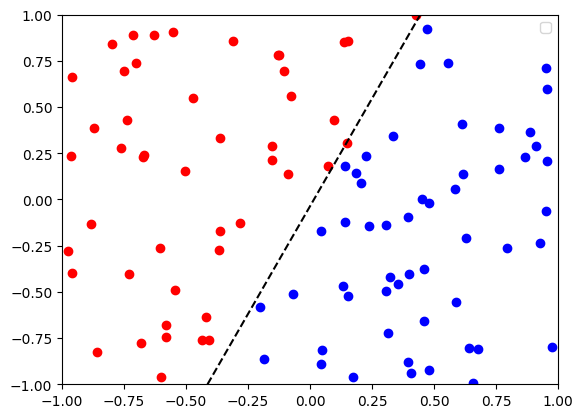

In [56]:
# implement gradient descent on the negative log likelihood yourself
# DO NOT USE TORCH YET
num_iters = 50000
lr = 0.02

# initialize the weights
w = np.random.randn(2)
b = np.random.randn()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def nll(x, y, w, b):
    # Fill in the negative log likelihood function here

losses = []
for i in range(num_iters):
    # Fill in the gradient descent loop here

plt.figure()
plt.plot(losses)
plt.show()

# plot the decision boundary. This will grid over the space and evaluate the model at each point. It then plots the boundary corresponding to where the model
# predicts a 50% probability of being in class 1. 
# If you're feeling fancy, vectorize it!
plt.figure()
plt.scatter(x[y==1, 0], x[y==1, 1], color='red')
plt.scatter(x[y==0, 0], x[y==0, 1], color='blue')
x_space = np.linspace(-1, 1, 100)
y_space = np.linspace(-1, 1, 100)
X_mesh, Y_mesh = np.meshgrid(x_space, y_space)
Z = np.zeros_like(X_mesh)
for i in range(100):
    for j in range(100):
        Z[i, j] = sigmoid(np.array([X_mesh[i, j], Y_mesh[i, j]]) @ w + b)
# create a level 0 contour with a label
plt.contour(X_mesh, Y_mesh, Z, levels=[0.5], colors='black', linestyles='dashed')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.show()


In [57]:
# for your convenience, here are the graphs corresponding to the right answer

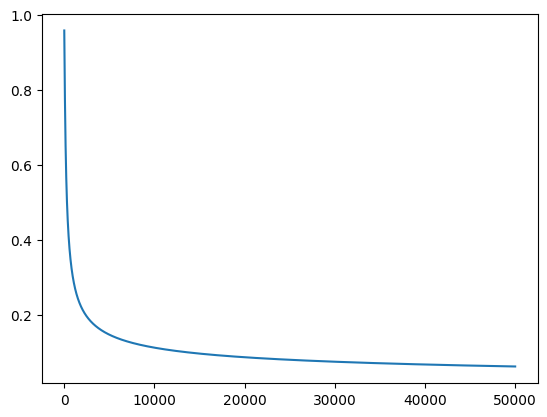
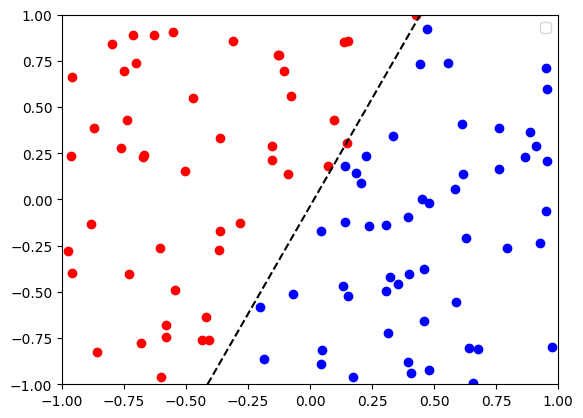

## Question 1.3 - Not linearly separable data
In the prior problem, I told you / you could see that the data could be predicted perfectly by a linear classifier. However, this is not always the case. In this problem, I've generated a dataset that cannot be separated by a line. Now one solution to this problem is to transform the data into a higher-dimensional space where it can be separated by a line. For example, given a dataset with features $x$, we could, if we wanted, create a new dataset with features $[x, x^2, x^3, x^4, x^5]$ or $[x. sin(x), 1/x]$ etc. Any transformation of the features is possible. Then, we perform our regression / classification in this new space instead of the original one. So, here we've made a dataset that can't be linearly separated. Your job is to design a feature space that can be used to separate out this data and then implement gradient descent to find the values of $w$ and $b$ that minimize the negative log-likelihood. Later, we'll see that part of the wonder of neural networks is that they'll frequently do this job for us, removing the job of feature engineering.

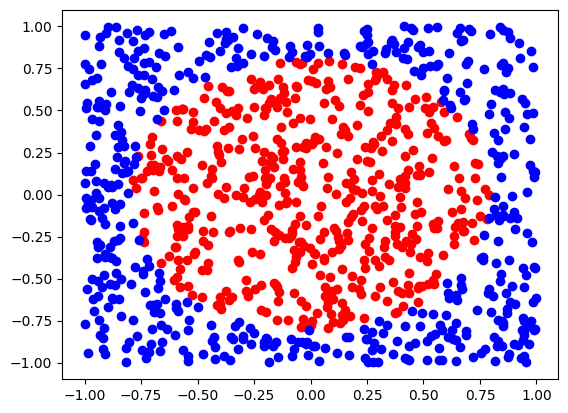

In [59]:
with open('Data/Homework_1/secret_data.pkl', 'rb') as f:
    data = pkl.load(f)
    x, y = data
plt.figure()
plt.scatter(x[y==1, 0], x[y==1, 1], color='red')
plt.scatter(x[y==0, 0], x[y==0, 1], color='blue')
plt.show()

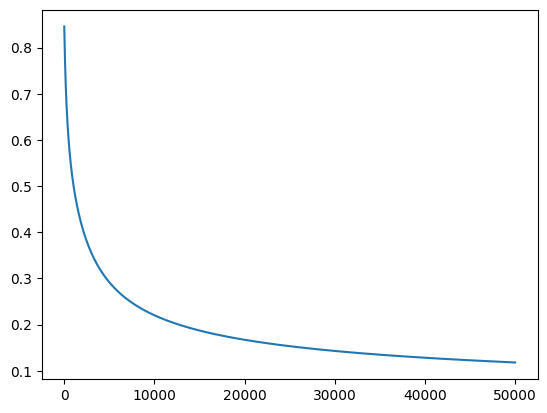

/tmp/ipykernel_1005378/1504527322.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


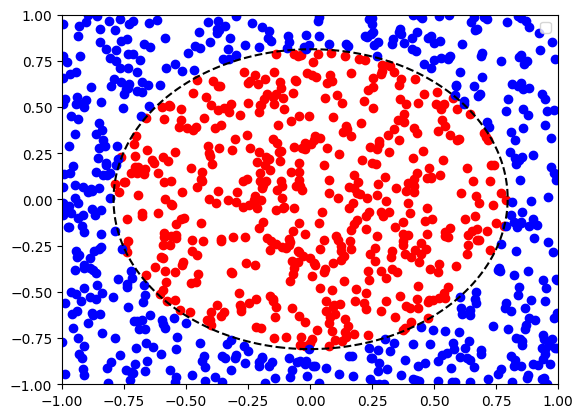

In [62]:
def featurize(x):
    """Take in x and return a new numpy array with the features you want"""
    # Fill in the featurize function here

# implement gradient descent on the negative log likelihood yourself
# DO NOT USE TORCH YET
num_iters = 50000
lr = 0.02

# initialize the weights
new_x = np.array([featurize(x_i) for x_i in x])
w = np.random.randn(new_x.shape[-1])
b = np.random.randn()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def nll(x, y, w, b):
    # fill in the natural log likelihood function here

losses = []
for i in range(num_iters):
    # fill in the gradient descent function here


plt.figure()
plt.plot(losses)
plt.show()

# plot the decision boundary. This will grid over the space and evaluate the model at each point. It then plots the boundary corresponding to where the model
# predicts a 50% probability of being in class 1. 
# If you're feeling fancy, vectorize it!
plt.figure()
plt.scatter(x[y==1, 0], x[y==1, 1], color='red')
plt.scatter(x[y==0, 0], x[y==0, 1], color='blue')
x_space = np.linspace(-1, 1, 100)
y_space = np.linspace(-1, 1, 100)
X_mesh, Y_mesh = np.meshgrid(x_space, y_space)
Z = np.zeros_like(X_mesh)
for i in range(100):
    for j in range(100):
        Z[i, j] = sigmoid(featurize(np.array([X_mesh[i, j], Y_mesh[i, j]])) @ w + b)
# create a level 0 contour with a label
plt.contour(X_mesh, Y_mesh, Z, levels=[0.5], colors='black', linestyles='dashed')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.show()




In [60]:
def featurize(x):
    """Take in x and return a new numpy array with the features you want"""
    return np.array([x[0], x[1], x[0]**2, x[1]**2, x[0]*x[1]])

# implement gradient descent on the negative log likelihood yourself
# DO NOT USE TORCH YET
num_iters = 50000
lr = 0.02

# initialize the weights
new_x = np.array([featurize(x_i) for x_i in x])
new_x.shape

(1000, 5)

# Question 2 - Pytorch practice
Now, we're going to redo linear regression using PyTorch tooling to see how it makes life easier. Later, we'll unpack some of the internals to see how it's actually doing this.

## Torch Modules
Torch allows us to define sequences of operations and wrap them all up in a class that can be called like a function. This is done by defining a class that inherits from `torch.nn.Module`. This class should have an `__init__` function that defines all the parameters of the model and a `forward` function that defines how the model is run.

```python
class ExampleModule(torch.nn.Module):
    def __init__(self):
        super(ExampleModule, self).__init__()
        self.linear = torch.nn.Linear(1, 1)
        
    def forward(self, x):
        return self.linear(x)
```
This class uses a linear layer to map from a 1-dimensional input to a 1-dimensional output. We can then call this model like a function. The invocation of this module forms a layer of a computational graph. 

```python
model = ExampleModule()
model(torch.tensor([1.0]))
```

So, going back to our example of a backwards call, we can pass some inputs through our module and use them to update the parameters of the model. This is done by calling `backward` on the output of the model. 

```python
model = ExampleModule()
x = torch.tensor([1.0], requires_grad=True)
y = model(x)
y.backward()
```

In [79]:
class ExampleModule(torch.nn.Module):
    def __init__(self):
        super(ExampleModule, self).__init__()
        # this is a linear layer. It takes in a feature of dimension 1, outputs a feature of dimension 1, and has a bias term.
        # so essentially, it represents the transformation w*x + b
        self.linear = torch.nn.Linear(in_features=1, out_features=1, bias=True)
        
    def forward(self, x):
        return self.linear(x)
    
model = ExampleModule()
print(model)
x = torch.tensor([1.0], requires_grad=True)
y = model(x)
y.backward()

# we can loop through model parameters like this
for param in model.parameters():
    print(param.grad)
# we can see that the gradient of y with respect to the parameter in the linear layer is 1.0. Does this make sense to you?

ExampleModule(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
tensor([[1.]])
True
tensor([1.])
True


## Now, lets illustrate what a training loop looks like in PyTorch for this model
We are going to make a really trivial loss function, trying to make the output of the model equal to 3. We'll then run a training loop to try to make the output of the model equal to 3.

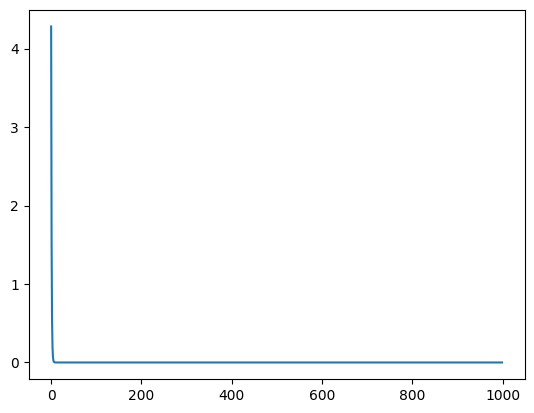

In [88]:
model = ExampleModule()
# note that we're setting requires_grad false here, this is because
# we're trying to take derivatives with respect to the parameters of the model
# not with respect to x
x = torch.tensor([[1.0]], requires_grad=False)
learning_rate = 0.1
losses = []
for i in range(1000):
    y = model(x)
    loss = (y-3)**2
    # note that .item is used to extract the value from a tensor and detach it 
    # from the computational graph. This ensure that you can't take derivatives through it.
    losses.append(loss.item())
    loss.backward()
    # we can update the weights using gradient descent
    # the torch.no_grad() is used to tell pytorch that we don't want to keep track of these operations in the computational graph
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    # we need to zero out the gradients before the next iteration
    model.zero_grad()
plt.figure()
plt.plot(losses)
plt.show()

One **really** important thing to pay attention to in the above bit of code is the `model.zero_grad()`. In torch the gradients accumulate, meaning that they don't reset to zero after each iteration and are simply added to the previous value in .grad. This is useful in some cases, but in our case, we want to reset the gradients to zero after each iteration.

# Problem 2 - Implementing logistic regression in PyTorch
Having manually implemented linear regression, lets see how PyTorch makes it easier! In the following example, I've placed out a sketch of a logistic regression model. Your job is to fill in the missing parts and train the model on the dataset I've provided. Any section marked with `pass` should be filled in.

In [ ]:
# Implement logistic regression as a torch module
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        # insert the layers
        pass
        
    def forward(self, x):
        # insert the forward pass
        pass
        
with open('Data/Homework_1/linear_data.pkl', 'rb') as f:
    data = pkl.load(f)
    x, y = data
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
model = LogisticRegression()

def nll(x, y, model):
    # fill in the negative log likelihood function here
    pass

losses = []
learning_rate = 0.1
for i in range(1000):
    # fill in a torch learning loop here
    loss = nll(x, y, model)
    losses.append(loss.item())
    
plt.figure()
plt.plot(losses)
plt.show()
